In [370]:
%pip install netCDF4
%pip install zstandard
%pip install numcodecs

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [371]:
import os
from netCDF4 import Dataset
import zstandard as zstd
import numcodecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [372]:
def read_file_with_var(read_file_name, var_name, round):
    data = Dataset("data/" + read_file_name)

    var = data.variables[var_name]
    var_data = var[:]

    if round:
        var_rounded = var_data * 10 // 1 / 10
        output = var_rounded.tobytes()
        return output
    else:
        output = var_data.tobytes()
        return output

In [373]:
def zstd_compress(data):
    cctx = zstd.ZstdCompressor()
    compressed = cctx.compress(data)
    return compressed

In [374]:
def zlib_compress(data):
    zlib = numcodecs.Zlib(level=9)
    compressed = zlib.encode(data)
    return compressed

In [375]:
def gzip_compress(data):
    gzip = numcodecs.gzip.GZip(level=9)
    compressed = gzip.encode(data)
    return compressed

In [376]:
def blosc_compress(data):
    blosc = numcodecs.Blosc(cname="blosclz", clevel=9, shuffle=numcodecs.blosc.Blosc.BITSHUFFLE, blocksize=0)
    compressed = blosc.encode(data)
    return compressed

In [377]:
def shuffle(data):
    shuffle = numcodecs.Shuffle()
    shuffled_data = shuffle.encode(data)
    return shuffled_data

In [378]:
def get_file_size(file_name):
        file_size = len(file_name)
        return file_size

In [388]:
def compression_ratio(original_file, compressed_file,):
    original_size = get_file_size(original_file)
    compressed_size = get_file_size(compressed_file)

    ratio = round(original_size / compressed_size, 3)

    data = [original_size, compressed_size, ratio]
    return data

In [389]:
def compress_all_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var_name in data.variables.keys():
        original = read_file_with_var(read_file_name, var_name, False)
        shuffled_data = shuffle(original)
        rounded_data = read_file_with_var(read_file_name, var_name, True)

        zstd_compressed_obj = zstd_compress(original)
        zstd_compression_data = compression_ratio(original, zstd_compressed_obj)

        zstd_compression_obj_shuffled = zstd_compress(shuffled_data)
        zstd_compression_data_shuffled = compression_ratio(original, zstd_compression_obj_shuffled)

        zstd_compression_obj_rounded = zstd_compress(rounded_data)
        zstd_compression_data_rounded = compression_ratio(original, zstd_compression_obj_rounded)

        zlib_compressed_obj = zlib_compress(original)
        zlib_compression_data = compression_ratio(original, zlib_compressed_obj)

        zlib_compression_obj_shuffled = zlib_compress(shuffled_data)
        zlib_compression_data_shuffled = compression_ratio(original, zlib_compression_obj_shuffled)

        zlib_compression_obj_rounded = zlib_compress(rounded_data)
        zlib_compression_data_rounded = compression_ratio(original, zlib_compression_obj_rounded)

        gzip_compressed_obj = gzip_compress(original)
        gzip_compression_data = compression_ratio(original, gzip_compressed_obj)

        gzip_compression_obj_shuffled = gzip_compress(shuffled_data)
        gzip_compression_data_shuffled = compression_ratio(original, gzip_compression_obj_shuffled)
        
        gzip_compression_obj_rounded = gzip_compress(rounded_data)
        gzip_compression_data_rounded = compression_ratio(original, gzip_compression_obj_rounded)

        blosc_compressed_obj = blosc_compress(original)
        blosc_compression_data = compression_ratio(original, blosc_compressed_obj)

        blosc_compression_obj_shuffled = blosc_compress(shuffled_data)
        blosc_compression_data_shuffled = compression_ratio(original, blosc_compression_obj_shuffled)
        
        blosc_compression_obj_rounded = blosc_compress(rounded_data)
        blosc_compression_data_rounded = compression_ratio(original, blosc_compression_obj_rounded)

        compression_ratios[var_name] = {
            "zstd_ratio": zstd_compression_data[2],
            "zstd_ratio_shuffled": zstd_compression_data_shuffled[2],
            "zstd_ratio_rounded": zstd_compression_data_rounded[2],
            "zlib_ratio": zlib_compression_data[2],
            "zlib_ratio_shuffled": zlib_compression_data_shuffled[2],
            "zlib_ratio_rounded": zlib_compression_data_rounded[2],
            "gzip_ratio": gzip_compression_data[2],
            "gzip_ratio_shuffled": gzip_compression_data_shuffled[2],
            "gzip_ratio_rounded": gzip_compression_data_rounded[2],
            "blosc_ratio": blosc_compression_data[2],
            "blosc_ratio_shuffled": blosc_compression_data_shuffled[2],
            "blosc_ratio_rounded": blosc_compression_data_rounded[2]
        }

        size_comparison[var_name] = {
            "original": zstd_compression_data[0],
            "zstd": zstd_compression_data[1],
            "zstd_shuffled": zstd_compression_data_shuffled[1],
            "zstd_rounded": zstd_compression_data_rounded[1],
            "zlib": zlib_compression_data[1],
            "zlib_shuffled": zlib_compression_data_shuffled[1],
            "zlib_rounded": zlib_compression_data_rounded[1],
            "gzip": gzip_compression_data[1],
            "gzip_shuffled": gzip_compression_data_shuffled[1],
            "gzip_rounded": gzip_compression_data_rounded[1],
            "blosc": blosc_compression_data[1],
            "blosc_shuffled": blosc_compression_data_shuffled[1],
            "blosc_rounded": blosc_compression_data_rounded[1]
        }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [390]:
compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

Compression ratios written to data/output/ratios/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_ratios.json
File size comparisons written to data/output/comparison/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_comparison.json


In [391]:
def original_ratio_plot(data):
    df = pd.DataFrame(data)

    original = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 1.5/len(categories)

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for i, method in enumerate(original.index):
        ax.bar(x + (i - len(categories)/2) * width, original.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])

    ax.set_title('Compression Ratios by Algorithm')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [392]:
def shuffled_ratio_plot(data):
    df = pd.DataFrame(data)

    non_shuffled = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]
    shuffled = df.loc[[col for col in df.index if 'shuffled' in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 0.1

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    shuffled_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']

    for i, method in enumerate(non_shuffled.index):
        ax.bar(x + i * (width * 2), non_shuffled.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])
        ax.bar(x + i * (width * 2) + width, shuffled.loc[method + '_shuffled'], width=width, 
            label=f'{method} Shuffled', alpha=0.7, color=shuffled_colors[i % len(shuffled_colors)])

    ax.set_title('Non-Shuffled vs Shuffled Compression Ratios')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [393]:
def rounded_ratio_plot(data):
    df = pd.DataFrame(data)

    non_rounded = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]
    rounded = df.loc[[col for col in df.index if 'rounded' in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 0.1

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    rounded_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']

    for i, method in enumerate(non_rounded.index):
        ax.bar(x + i * (width * 2), non_rounded.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])
        ax.bar(x + i * (width * 2) + width, rounded.loc[method + '_rounded'], width=width, 
            label=f'{method} Rounded', alpha=0.7, color=rounded_colors[i % len(rounded_colors)])

    ax.set_title('Non-Rounded vs Rounded Compression Ratios')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [402]:
def ratio_plots(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    os.makedirs(directory_path, exist_ok=True)

                    original_plot = original_ratio_plot(data)
                    original_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_original.png')))

                    shuffle_plot = shuffled_ratio_plot(data)
                    shuffle_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_shuffle.png')))

                    rounded_plot = rounded_ratio_plot(data)
                    rounded_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_rounded.png')))

                    original_plot.show()
                    shuffle_plot.show()
                    rounded_plot.show()

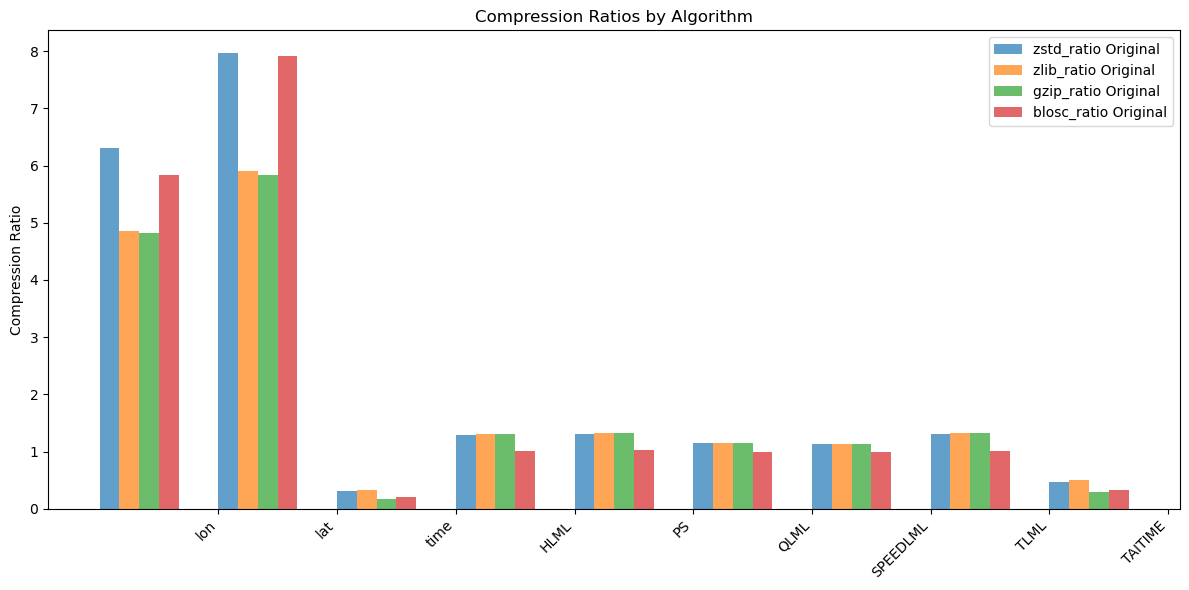

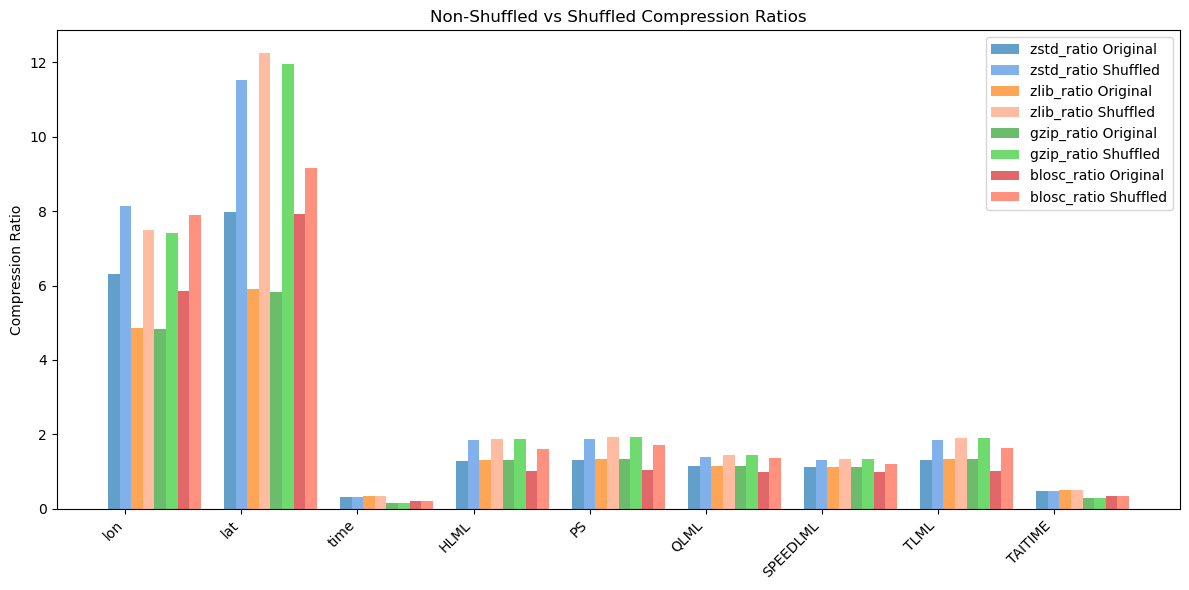

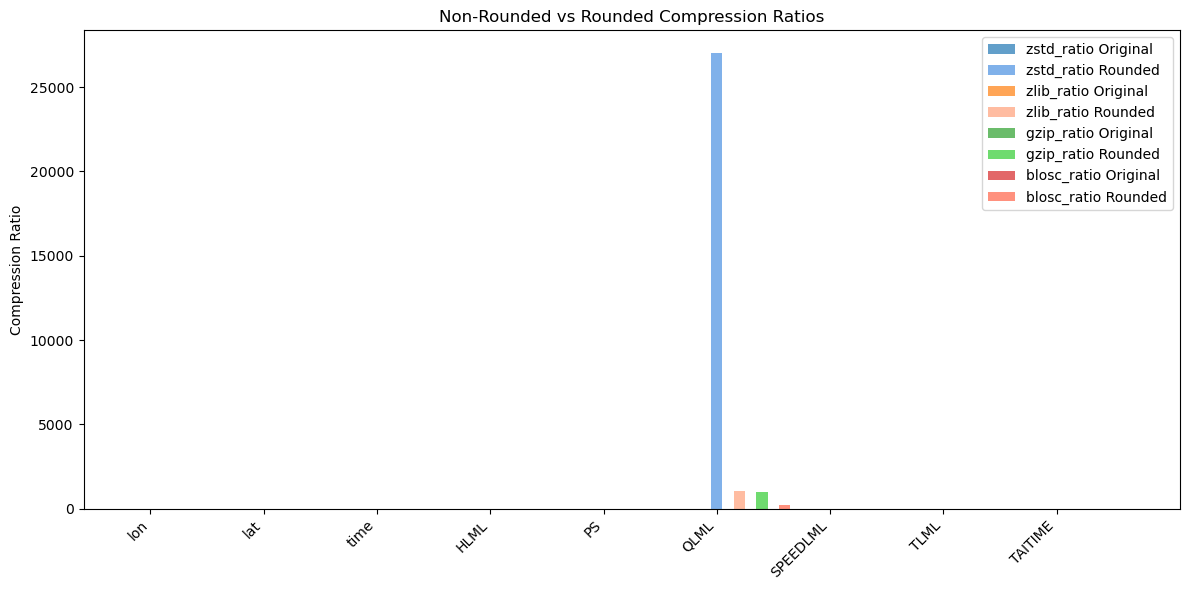

In [403]:
ratio_plots("data/output/ratios/")

In [404]:
# def comparison_plot(directory_path):
#     for filename in os.listdir(directory_path):
#         if filename.endswith('.json'):
#             file_path = os.path.join(directory_path, filename)
            
#             if os.path.isfile(file_path):
#                 with open(file_path, 'r') as file:
#                     data = json.load(file)

#                     keys = list(data.keys())
#                     libraries = [lib for lib in data[keys[0]].keys() if lib != "original"]
                    
#                     original_values = [data[key]['original'] for key in keys]
                    
#                     compressed_values = {lib: [data[key][lib] for key in keys] for lib in libraries}

#                     x = np.arange(len(keys))
#                     width = 0.8 / (len(libraries) + 1)

#                     fig, ax = plt.subplots(figsize=(12, 6))

#                     ax.bar(x - len(libraries)/2 * width, original_values, width, label='Original', color='skyblue')

#                     for i, lib in enumerate(libraries):
#                         ax.bar(x + (i + 1 - len(libraries) / 2) * width, compressed_values[lib], width, label=lib)

#                     ax.set_xlabel('Keys')
#                     ax.set_ylabel('Size')
#                     ax.set_title('Original vs Compressed Sizes by Library')
#                     ax.set_xticks(x)
#                     ax.set_xticklabels(keys, rotation=45)
#                     ax.legend()

#                     plt.tight_layout()

#                     output_dir = "data/output/comparison/"
#                     os.makedirs(output_dir, exist_ok=True)
#                     plt.savefig(os.path.join(output_dir, filename.replace('.json', '.png')))
#                     plt.show()